In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.compose import ColumnTransformer
from category_encoders import CountEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss,accuracy_score,classification_report
import os
import warnings

#### Data Importing and Preparation

In [2]:
# Train features is the features for the training set, each row corresponds to a treatment
# Includes gene expression data and cell viability data
train_features = pd.read_csv('train_features.csv')

# The scored training targets. Drug marked as 1 if it activates a particular mechanism of action
train_targets = pd.read_csv('train_targets_scored.csv')

# Features for the test set where we need to make predictions
test_features = pd.read_csv('test_features.csv')

In [3]:
# Encoding categorical features
for col in ['cp_type', 'cp_time', 'cp_dose']:
    le = LabelEncoder()
    train_features[col] = le.fit_transform(train_features[col])
    test_features[col] = le.transform(test_features[col])

# Remove control group samples from the training data
train_indices = train_features[train_features['cp_type'] != 0].index
train_features_filtered = train_features.loc[train_indices]
train_targets_filtered = train_targets.loc[train_indices]

# Standardize the numerical features (gene expression and cell viability)
scaler = StandardScaler()
num_cols = [col for col in train_features.columns if col.startswith('g-') or col.startswith('c-')]
train_features_filtered[num_cols] = scaler.fit_transform(train_features_filtered[num_cols])
test_features[num_cols] = scaler.transform(test_features[num_cols])

X_train, X_valid, y_train, y_valid = train_test_split(train_features_filtered, train_targets_filtered, test_size=0.2, random_state=42)

# Conversion into binary matrices and dropping sig_id (irrelevant for autoecndoer)

X_train = X_train.drop(columns=['sig_id'], errors='ignore')
X_valid = X_valid.drop(columns=['sig_id'], errors='ignore')

X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')

y_train = y_train.drop(columns=['sig_id'], errors='ignore')
y_valid = y_valid.drop(columns=['sig_id'], errors='ignore')

y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')

#### Autoencoder on both cell and gene features

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

input_dim = X_train.shape[1]  

inputs = Input(shape=(input_dim,))
encoded = Dense(2100, activation='relu')(inputs)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)  # Dropout added for regularization
encoded = Dense(1700, activation='relu')(encoded)
decoded = Dense(1700, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.2)(decoded)  # Dropout added for regularization
decoded = Dense(2100, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
output = Dense(input_dim)(decoded) 

# Autoencoder model
autoencoder = Model(inputs, output)

# Learning rate scheduler setup
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_autoencoder_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = autoencoder.fit(X_train, X_train,  
                epochs=100,
                batch_size=512,
                shuffle=True,
                validation_data=(X_valid, X_valid),
                callbacks=[early_stopping, model_checkpoint, lr_scheduler])


2024-05-04 18:08:42.019668: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-04 18:08:42.019750: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-04 18:08:42.019760: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-04 18:08:42.019794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-04 18:08:42.019816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-05-04 18:08:43.326684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-04 18:08:43.396680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


35/35 [==============================] - ETA: 0s - loss: 0.8141
Epoch 1: val_loss improved from inf to 10.70480, saving model to best_autoencoder_model.h5


/Users/amansharma/miniforge3/envs/qbio499/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 6s 120ms/step - loss: 0.8141 - val_loss: 10.7048 - lr: 0.0010
Epoch 2/100
34/35 [============================>.] - ETA: 0s - loss: 0.5054
Epoch 2: val_loss improved from 10.70480 to 1.57886, saving model to best_autoencoder_model.h5
35/35 [==============================] - 2s 67ms/step - loss: 0.5058 - val_loss: 1.5789 - lr: 0.0010
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.4900
Epoch 3: val_loss improved from 1.57886 to 0.83553, saving model to best_autoencoder_model.h5
35/35 [==============================] - 4s 109ms/step - loss: 0.4900 - val_loss: 0.8355 - lr: 0.0010
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 0.4506
Epoch 4: val_loss improved from 0.83553 to 0.58902, saving model to best_autoencoder_model.h5
35/35 [==============================] - 4s 104ms/step - loss: 0.4506 - val_loss: 0.5890 - lr: 0.0010
Epoch 5/100
34/35 [============================>.] - ETA: 0s - loss: 0.4331
Epoch

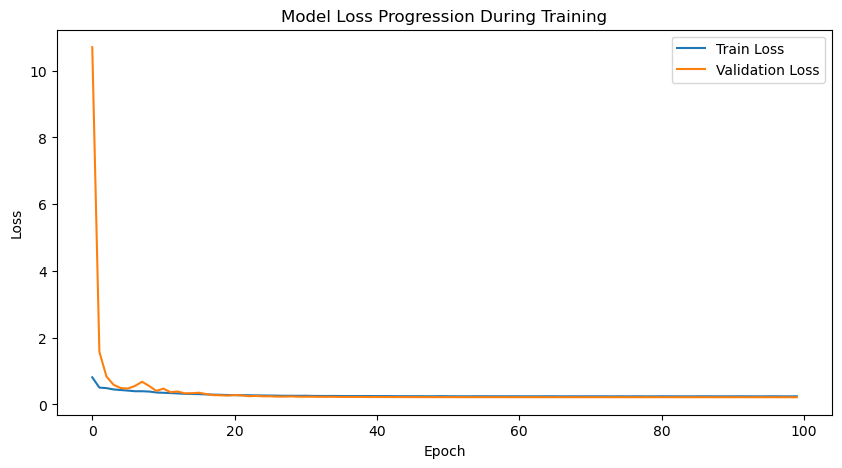

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### t-SNE

549/549 [==============================] - 1s 2ms/step


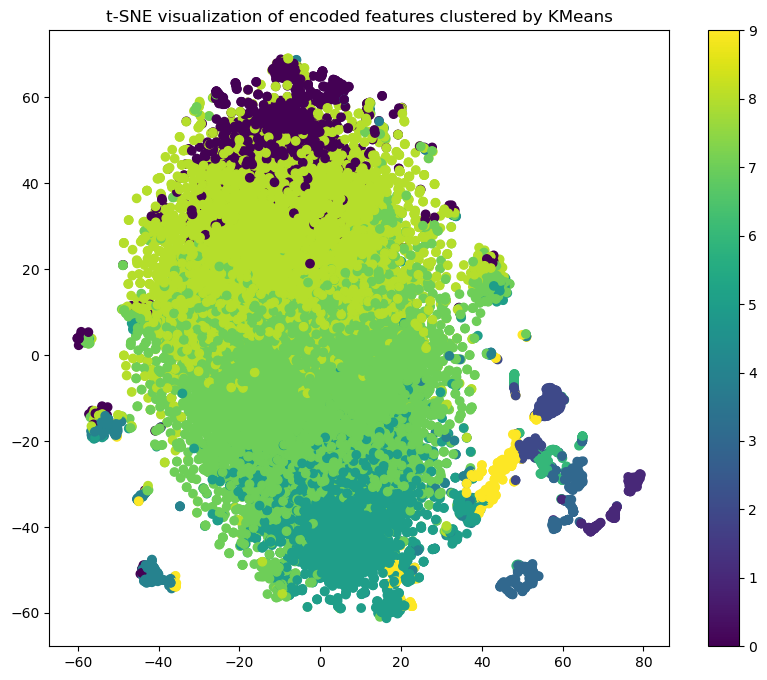

In [6]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

encoder = Model(inputs=autoencoder.input, outputs=encoded)
encoded_train = encoder.predict(X_train)

kmeans = KMeans(n_clusters=10, random_state=42).fit(encoded_train)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(encoded_train)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('t-SNE visualization of encoded features clustered by KMeans')
plt.colorbar()
plt.show()

#### Reconstruction Error Distribution

549/549 [==============================] - 3s 5ms/step


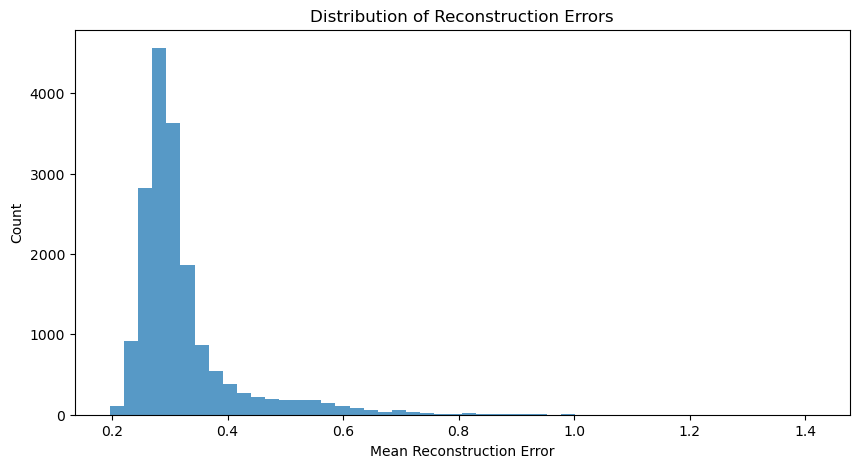

In [7]:
reconstructed = autoencoder.predict(X_train)

# Calculate reconstruction errors
errors = np.mean(np.abs(X_train - reconstructed), axis=1)

# Plot the error distribution
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, alpha=0.75)
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Mean Reconstruction Error')
plt.ylabel('Count')
plt.show()

#### Original vs. Reconstructed Data - First 10 Features

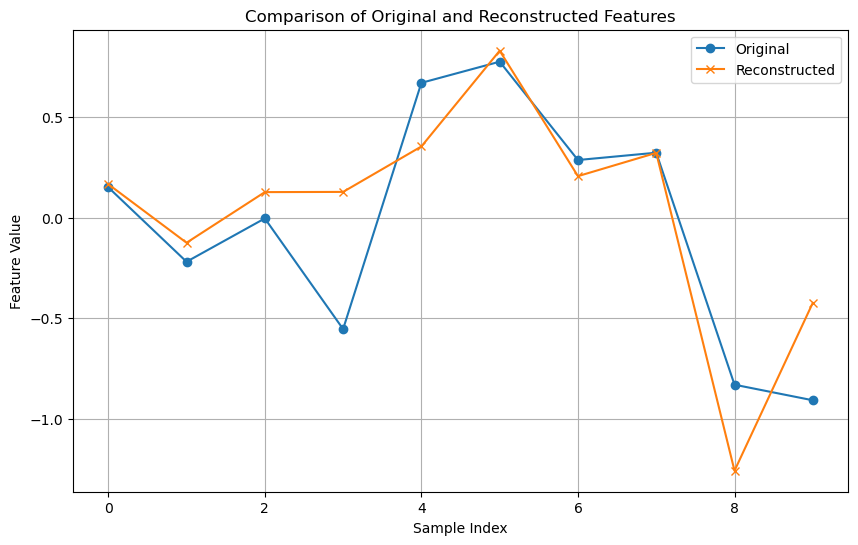

In [10]:
reconstructed_df = pd.DataFrame(reconstructed, index=X_train.index, columns=X_train.columns)

feature_index = 10  # Ensure this is the correct index for the feature you want to examine
indices = np.random.choice(X_train.shape[0], 10, replace=False)

# Retrieve original and reconstructed features for visualization
original_features = X_train.iloc[indices, feature_index]
reconstructed_features = reconstructed_df.iloc[indices, feature_index]

plt.figure(figsize=(10, 6))
plt.plot(original_features.values, label='Original', marker='o')  # Use .values to get numpy array for plotting
plt.plot(reconstructed_features.values, label='Reconstructed', marker='x')  # Use .values here too
plt.title('Comparison of Original and Reconstructed Features')
plt.ylabel('Feature Value')
plt.xlabel('Sample Index')
plt.legend()
plt.grid(True)
plt.show()

#### Original vs. Reconstructed - Random Features

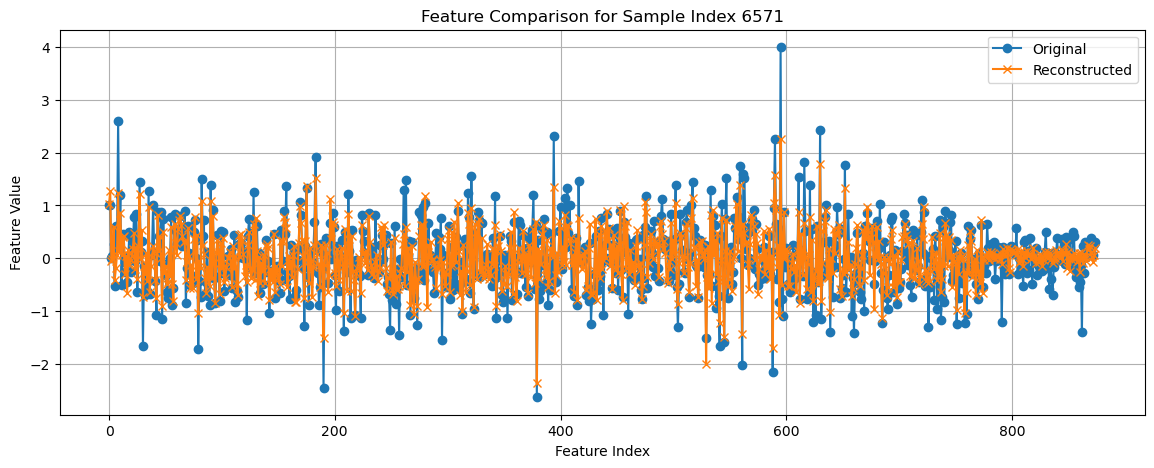

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `X_train` is a DataFrame and `reconstructed` is a numpy array converted to DataFrame as before
reconstructed_df = pd.DataFrame(reconstructed, index=X_train.index, columns=X_train.columns)

# Generate a random sample index
sample_index = np.random.choice(X_train.shape[0])

# Access the row corresponding to `sample_index` using `.iloc` for both original and reconstructed data
original_sample = X_train.iloc[sample_index].values  # Using .values to get the array for plotting
reconstructed_sample = reconstructed_df.iloc[sample_index].values

# Plotting the comparison
plt.figure(figsize=(14, 5))
plt.plot(original_sample, label='Original', marker='o')
plt.plot(reconstructed_sample, label='Reconstructed', marker='x')
plt.title(f'Feature Comparison for Sample Index {sample_index}')
plt.ylabel('Feature Value')
plt.xlabel('Feature Index')
plt.legend()
plt.grid(True)
plt.show()


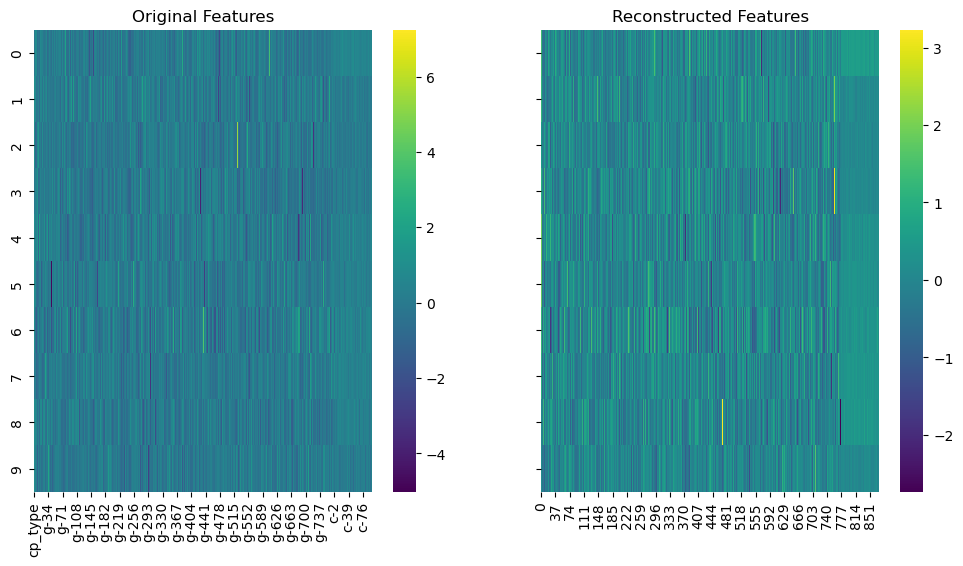

In [13]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sns.heatmap(X_train[:10], ax=axes[0], cmap='viridis')
axes[0].set_title('Original Features')
sns.heatmap(reconstructed[:10], ax=axes[1], cmap='viridis')
axes[1].set_title('Reconstructed Features')
plt.show()